In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
#psi4.core.set_output_file('output.dat', False)
import time
from scipy.optimize import curve_fit


In [ ]:
min_length = 1.0  # Minimum bond length
max_length = 2.2  # Maximum bond length

# Define the equilibrium bond length
equilibrium_length = 1.5500000000000003  # Adjust as needed

# Specify the number of data points you want near the equilibrium bond length
num_points_near_equilibrium = 25

# Specify the number of data points in the remaining range
num_points_remaining = 25

# Create a non-uniform grid
grid_near_equilibrium = np.linspace(equilibrium_length - 0.5, equilibrium_length + 0.5, num_points_near_equilibrium)
grid_remaining = np.linspace(min_length, max_length, num_points_remaining)

# Combine the grids to create the non-uniform grid
r_array = np.sort(np.concatenate((grid_near_equilibrium, grid_remaining)))
#print(r_array)

In [2]:
# setup basic arguments for qed-ci calculation

# z-matrix for LIH
mol_str_LiH = """
Li
H 1 1.8
symmetry c1
"""

# z-matrix ffor H2
mol_str_H2 = """
H
H 1 0.74
symmetry c1
"""

# options for Psi4
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [4]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl_LiH = """
Li
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

r_array = np.linspace(0.2, 2.2, N_R)


# array for energies for LiH outside cavity
cavity_free_E_array_LiH = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_idx_LiH = 0
for r in r_array:
    mol_str_LiH = mol_tmpl_LiH.replace("**R**", str(r))
    mol_LiH = psi4.geometry(mol_str_LiH)
    print(mol_str_LiH)
    
    # call psi4 RHF
    scf_e, wfn_LiH = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_LiH = psi4.energy('fci/sto-3g',ref_wfn=wfn_LiH)
    
    # LiH no cavity
    LiH = PFHamiltonianGenerator(mol_str_LiH, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(LiH.CIeigs[0], fci_energy_LiH)
    
    # LiH with cavity
    LiH_cav = PFHamiltonianGenerator(mol_str_LiH, options_dict, cavity_dict)
    cavity_free_E_array_LiH[r_idx_LiH,:] = LiH.CIeigs[:N_el]
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1
    
    
    


Li
H 1 0.2
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:24 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------------------------------------

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1870231972E-01.
  Reciprocal condition number of the overlap matrix is 5.6205319408E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7147519588470459 seconds

Li
H 1 0.24081632653061225
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:26 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                     

  Nalpha       = 2
  Nbeta        = 2

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-10
  Density threshold  = 1.00e-10
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 4
    Number of basis functions: 6
    Number of Cartesian functions: 6
    Spherical Harmonics?: true
    Max angular momentum: 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there

 Completed Hamiltonian build in 0.7341241836547852 seconds

Li
H 1 0.2816326530612245
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:27 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4141654253E-01.
  Reciprocal condition number of the overlap matrix is 6.7840724881E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7099897861480713 seconds

Li
H 1 0.3224489795918367
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:29 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.21073833784516   -7.21074e+00   0.00000e+00 
   @RHF iter   1:    -6.04396843372238    1.16677e+00   4.00871e-02 ADIIS/DIIS
   @RHF iter   2:    -6.06742739686105   -2.34590e-02   3.18172e-03 ADIIS/DIIS
   @RHF iter   3:    -6.06768341601879   -2.56019e-04   2.48894e-04 ADIIS/DIIS
   @RHF iter   4:    -6.06769055284249   -7.13682e-06   7.80560e-05 DIIS
   @RHF iter   5:    -6.06769187194108   -1.31910e-06   3.47107e-06 DIIS
   @RHF iter   6:    -6.06769187376747   -1.82638e-09   1.18739e-07 DIIS
   @RHF iter   7:    -6.06769187377030   -2.83684e-12   5.13442e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6968860626220703 seconds

Li
H 1 0.363265306122449
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:31 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

   @RHF iter   3:    -6.38901031450489   -2.37369e-04   1.83904e-04 ADIIS/DIIS
   @RHF iter   4:    -6.38901199641025   -1.68191e-06   3.09912e-05 DIIS
   @RHF iter   5:    -6.38901222710864   -2.30698e-07   9.79576e-06 DIIS
   @RHF iter   6:    -6.38901225145479   -2.43461e-08   9.98937e-08 DIIS
   @RHF iter   7:    -6.38901225145716   -2.37144e-12   1.25787e-09 DIIS
   @RHF iter   8:    -6.38901225145717   -1.59872e-14   8.40077e-13 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -3.251964     2A     -0.276514  

    Virtual:                                                              

       3A      0.007714     4A      0.058600     5A      0.058600  
       6A      0.829556  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -6.38901225

 Completed Hamiltonian build in 0.7036440372467041 seconds

Li
H 1 0.4040816326530612
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:33 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.7361263007E-01.
  Reciprocal condition number of the overlap matrix is 8.5141173779E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6949260234832764 seconds

Li
H 1 0.4448979591836735
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:34 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   3:    -6.82343640818264   -1.75294e-04   1.65703e-04 ADIIS/DIIS
   @RHF iter   4:    -6.82343768294156   -1.27476e-06   3.85032e-05 DIIS
   @RHF iter   5:    -6.82343817167654   -4.88735e-07   1.68850e-05 DIIS
   @RHF iter   6:    -6.82343828799151   -1.16315e-07   3.12424e-08 DIIS
   @RHF iter   7:    -6.82343828799161   -1.01252e-13   2.84585e-09 DIIS
   @RHF iter   8:    -6.82343828799160    3.55271e-15   3.36261e-12 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.997367     2A     -0.270437  

    Virtual:                                                              

       3A      0.012793     4A      0.083016     5A      0.083016  
       6A      0.740016  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -6.82343828

 Completed Hamiltonian build in 0.7256999015808105 seconds

Li
H 1 0.4857142857142857
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:36 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.8998361646E-01.
  Reciprocal condition number of the overlap matrix is 9.4539629089E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.714339017868042 seconds

Li
H 1 0.5265306122448979
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.9633861729E-01.
  Reciprocal condition number of the overlap matrix is 9.8390180491E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7172520160675049 seconds

Li
H 1 0.5673469387755101
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:40 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.0156133216E-01.
  Reciprocal condition number of the overlap matrix is 1.0169539914E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.706855058670044 seconds

Li
H 1 0.6081632653061224
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:41 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.0579408717E-01.
  Reciprocal condition number of the overlap matrix is 1.0451348231E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6998357772827148 seconds

Li
H 1 0.6489795918367347
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:43 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.61628325955126   -7.61628e+00   0.00000e+00 
   @RHF iter   1:    -7.39716964009992    2.19114e-01   1.27486e-02 ADIIS/DIIS
   @RHF iter   2:    -7.39924326054058   -2.07362e-03   1.44563e-03 ADIIS/DIIS
   @RHF iter   3:    -7.39927901787434   -3.57573e-05   1.46598e-04 ADIIS/DIIS
   @RHF iter   4:    -7.39928363777004   -4.61990e-06   7.57319e-05 DIIS
   @RHF iter   5:    -7.39928549981736   -1.86205e-06   1.85933e-06 DIIS
   @RHF iter   6:    -7.39928550009105   -2.73695e-10   1.73398e-08 DIIS
   @RHF iter   7:    -7.39928550009107   -1.95399e-14   1.18972e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6913230419158936 seconds

Li
H 1 0.689795918367347
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:45 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.60528299706292   -7.60528e+00   0.00000e+00 
   @RHF iter   1:    -7.46816838760027    1.37115e-01   1.10468e-02 ADIIS/DIIS
   @RHF iter   2:    -7.46984346031754   -1.67507e-03   1.22107e-03 ADIIS/DIIS
   @RHF iter   3:    -7.46986432892602   -2.08686e-05   5.13254e-05 DIIS
   @RHF iter   4:    -7.46986478996984   -4.61044e-07   3.06329e-05 DIIS
   @RHF iter   5:    -7.46986506304430   -2.73074e-07   2.03403e-06 DIIS
   @RHF iter   6:    -7.46986506389328   -8.48977e-10   7.93296e-08 DIIS
   @RHF iter   7:    -7.46986506389351   -2.25597e-13   1.62533e-10 DIIS
   @RHF iter   8

 Completed Hamiltonian build in 0.7037613391876221 seconds

Li
H 1 0.7306122448979591
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:46 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.1438389120E-01.
  Reciprocal condition number of the overlap matrix is 1.1089689903E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6964452266693115 seconds

Li
H 1 0.7714285714285714
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:48 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.1651424916E-01.
  Reciprocal condition number of the overlap matrix is 1.1265097916E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7004861831665039 seconds

Li
H 1 0.8122448979591836
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:50 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.1857372895E-01.
  Reciprocal condition number of the overlap matrix is 1.1437268714E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7003629207611084 seconds

Li
H 1 0.8530612244897959
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:52 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      


  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.55617313057869   -7.55617e+00   0.00000e+00 
   @RHF iter   1:    -7.66311001384720   -1.06937e-01   1.12353e-02 ADIIS/DIIS
   @RHF iter   2:    -7.66758437891255   -4.47437e-03   1.03624e-03 ADIIS/DIIS
   @RHF iter   3:    -7.66764452031591   -6.01414e-05   2.57411e-04 ADIIS/DIIS
   @RHF iter   4:    -7.66765573587939   -1.12156e-05   1.08505e-04 ADIIS/DIIS
   @RHF iter   5:    -7.66765843594569   -2.70007e-06   1.64567e-06 DIIS
   @RHF iter   6:    -7.66765843602028   -7.45883e-11   8.41546e-08 DIIS
   @RHF iter   7:    -7.66765843602101   -7.31859e-13   2.85104e-10 DIIS
   

 Completed Hamiltonian build in 0.7266740798950195 seconds

Li
H 1 0.8938775510204082
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:53 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.2306751825E-01.
  Reciprocal condition number of the overlap matrix is 1.1804296403E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7228679656982422 seconds

Li
H 1 0.9346938775510203
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:55 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.2574485243E-01.
  Reciprocal condition number of the overlap matrix is 1.2013120573E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7343490123748779 seconds

Li
H 1 0.9755102040816326
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:57 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.2883778125E-01.
  Reciprocal condition number of the overlap matrix is 1.2246592321E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7367870807647705 seconds

Li
H 1 1.0163265306122449
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:22:59 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3241923330E-01.
  Reciprocal condition number of the overlap matrix is 1.2509424892E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.73956298828125 seconds

Li
H 1 1.0571428571428572
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:01 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3654497825E-01.
  Reciprocal condition number of the overlap matrix is 1.2805499530E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7086660861968994 seconds

Li
H 1 1.0979591836734692
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:03 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.4125520590E-01.
  Reciprocal condition number of the overlap matrix is 1.3137930918E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.720008134841919 seconds

Li
H 1 1.1387755102040815
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:04 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.49485980002743   -7.49486e+00   0.00000e+00 
   @RHF iter   1:    -7.81024694655647   -3.15387e-01   1.51739e-02 ADIIS/DIIS
   @RHF iter   2:    -7.82039159944588   -1.01447e-02   1.56697e-03 ADIIS/DIIS
   @RHF iter   3:    -7.82059315055326   -2.01551e-04   4.65603e-04 ADIIS/DIIS
   @RHF iter   4:    -7.82063396052845   -4.08100e-05   7.79179e-05 DIIS
   @RHF iter   5:    -7.82063503995677   -1.07943e-06   1.03593e-06 DIIS
   @RHF iter   6:    -7.82063504014887   -1.92107e-10   6.78336e-09 DIIS
   @RHF iter   7:    -7.82063504014889   -1.50990e-14   1.07830e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7156932353973389 seconds

Li
H 1 1.1795918367346938
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:06 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   3:    -7.83105168605060   -2.18446e-04   4.80374e-04 ADIIS/DIIS
   @RHF iter   4:    -7.83109546895187   -4.37829e-05   6.37263e-05 DIIS
   @RHF iter   5:    -7.83109615996054   -6.91009e-07   1.15333e-06 DIIS
   @RHF iter   6:    -7.83109616016653   -2.05986e-10   9.81931e-09 DIIS
   @RHF iter   7:    -7.83109616016653   -5.32907e-15   9.48761e-10 DIIS
   @RHF iter   8:    -7.83109616016653    1.77636e-15   2.61820e-11 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.351019     2A     -0.313822  

    Virtual:                                                              

       3A      0.079311     4A      0.161197     5A      0.161197  
       6A      0.622491  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -7.83109616

 Completed Hamiltonian build in 0.7061471939086914 seconds

Li
H 1 1.220408163265306
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:08 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

   @RHF iter   3:    -7.83965371485461   -2.34329e-04   4.93533e-04 ADIIS/DIIS
   @RHF iter   4:    -7.83970021741849   -4.65026e-05   5.02690e-05 DIIS
   @RHF iter   5:    -7.83970062500580   -4.07587e-07   1.27833e-06 DIIS
   @RHF iter   6:    -7.83970062522087   -2.15076e-10   1.03041e-08 DIIS
   @RHF iter   7:    -7.83970062522088   -9.76996e-15   9.13554e-10 DIIS
   @RHF iter   8:    -7.83970062522088   -8.88178e-16   9.95889e-12 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.349023     2A     -0.312084  

    Virtual:                                                              

       3A      0.079519     4A      0.161699     5A      0.161699  
       6A      0.620871  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -7.83970062

 Completed Hamiltonian build in 0.7046158313751221 seconds

Li
H 1 1.2612244897959182
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:10 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.6628953806E-01.
  Reciprocal condition number of the overlap matrix is 1.4870623062E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.47882258279330   -7.47882e+00   0.00000e+00 
   @RHF iter   1:    -7.83428155037913   -3.55459e-01   1.63553e-02 ADIIS/DIIS
   @RHF iter   2:    -7.84637223430347   -1.20907e-02   1.71477e-03 ADIIS/DIIS
   @RHF iter   3:    -7.84662142255964   -2.49188e-04   5.05432e-04 ADIIS/DIIS
   @RHF iter   4:    -7.84667044557429   -4.90230e-05   3.85367

 Completed Hamiltonian build in 0.7024579048156738 seconds

Li
H 1 1.3020408163265305
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:11 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   2:    -7.85188415999509   -1.27305e-02   1.75117e-03 ADIIS/DIIS
   @RHF iter   3:    -7.85214715344042   -2.62993e-04   5.16344e-04 ADIIS/DIIS
   @RHF iter   4:    -7.85219856068112   -5.14072e-05   2.92127e-05 DIIS
   @RHF iter   5:    -7.85219868312449   -1.22443e-07   1.32969e-06 DIIS
   @RHF iter   6:    -7.85219868328434   -1.59850e-10   6.74067e-09 DIIS
   @RHF iter   7:    -7.85219868328434    1.77636e-15   1.07260e-09 DIIS
   @RHF iter   8:    -7.85219868328435   -5.32907e-15   1.02705e-11 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.346683     2A     -0.307704  

    Virtual:                                                              

       3A      0.079676     4A      0.162535     5A      0.162535  
       6A      0.613163  

    Final Occupation by Irrep:
              A 
    DOCC [    

 Completed Hamiltonian build in 0.7075629234313965 seconds

Li
H 1 1.3428571428571427
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:13 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.47029046480643   -7.47029e+00   0.00000e+00 
   @RHF iter   1:    -7.84274675711189   -3.72456e-01   1.70225e-02 ADIIS/DIIS
   @RHF iter   2:    -7.85612234238929   -1.33756e-02   1.78108e-03 ADIIS/DIIS
   @RHF iter   3:    -7.85639804147653   -2.75699e-04   5.26488e-04 ADIIS/DIIS
   @RHF iter   4:    -7.85645175714011   -5.37157e-05   2.27415e-05 DIIS
   @RHF iter   5:    -7.85645182932855   -7.21884e-08   1.05284e-06 DIIS
   @RHF iter   6:    -7.85645182939281   -6.42633e-11   6.27674e-09 DIIS
   @RHF iter   7:    -7.85645182939281   -8.88178e-16   9.97251e-11 DIIS
  Energy a

 Completed Hamiltonian build in 0.7022240161895752 seconds

Li
H 1 1.383673469387755
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:15 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.9142874890E-01.
  Reciprocal condition number of the overlap matrix is 1.6615727270E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7103233337402344 seconds

Li
H 1 1.424489795918367
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:17 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.46300063558473   -7.46300e+00   0.00000e+00 
   @RHF iter   1:    -7.84664269755311   -3.83642e-01   1.76188e-02 ADIIS/DIIS
   @RHF iter   2:    -7.86134298106060   -1.47003e-02   1.82116e-03 ADIIS/DIIS
   @RHF iter   3:    -7.86164053618610   -2.97555e-04   5.45135e-04 ADIIS/DIIS
   @RHF iter   4:    -7.86169882194865   -5.82858e-05   1.98823e-05 DIIS
   @RHF iter   5:    -7.86169887614994   -5.42013e-08   3.42498e-07 DIIS
   @RHF iter   6:    -7.86169887615524   -5.30864e-12   8.31090e-09 DIIS
   @RHF iter   7:    -7.86169887615526   -1.06581e-14   4.96692e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7146728038787842 seconds

Li
H 1 1.4653061224489794
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:18 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 4
    Number of basis functions: 6
    Number of Cartesian functions: 6
    Spherical Harmonics?: true
    Max angular momentum: 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:  

 Completed Hamiltonian build in 0.7091870307922363 seconds

Li
H 1 1.5061224489795917
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:20 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.2131451562E-01.
  Reciprocal condition number of the overlap matrix is 1.8735642844E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.688326358795166 seconds

Li
H 1 1.546938775510204
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:22 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45376611754051   -7.45377e+00   0.00000e+00 
   @RHF iter   1:    -7.84590103447151   -3.92135e-01   1.84232e-02 ADIIS/DIIS
   @RHF iter   2:    -7.86273471892688   -1.68337e-02   1.83057e-03 ADIIS/DIIS
   @RHF iter   3:    -7.86305495313936   -3.20234e-04   5.70705e-04 ADIIS/DIIS
   @RHF iter   4:    -7.86312030909219   -6.53560e-05   3.63762e-05 DIIS
   @RHF iter   5:    -7.86312048842548   -1.79333e-07   1.67049e-06 DIIS
   @RHF iter   6:    -7.86312048873117   -3.05688e-10   2.59176e-08 DIIS
   @RHF iter   7:    -7.86312048873119   -2.30926e-14   2.00710e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6966512203216553 seconds

Li
H 1 1.5877551020408163
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:23 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45104100367791   -7.45104e+00   0.00000e+00 
   @RHF iter   1:    -7.84424886161684   -3.93208e-01   1.86761e-02 ADIIS/DIIS
   @RHF iter   2:    -7.86184709081237   -1.75982e-02   1.81990e-03 ADIIS/DIIS
   @RHF iter   3:    -7.86217184092669   -3.24750e-04   5.78881e-04 ADIIS/DIIS
   @RHF iter   4:    -7.86223963915936   -6.77982e-05   4.47458e-05 DIIS
   @RHF iter   5:    -7.86223992084348   -2.81684e-07   1.88221e-06 DIIS
   @RHF iter   6:    -7.86223992125730   -4.13814e-10   3.07428e-08 DIIS
   @RHF iter   7:    -7.86223992125733   -3.55271e-14   2.39742e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6839570999145508 seconds

Li
H 1 1.6285714285714283
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:25 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.5497685471E-01.
  Reciprocal condition number of the overlap matrix is 2.1201871414E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6999459266662598 seconds

Li
H 1 1.6693877551020406
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:27 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.44601937522511   -7.44602e+00   0.00000e+00 
   @RHF iter   1:    -7.83924913820926   -3.93230e-01   1.91705e-02 ADIIS/DIIS
   @RHF iter   2:    -7.85847681067706   -1.92277e-02   1.77784e-03 ADIIS/DIIS
   @RHF iter   3:    -7.85880556198844   -3.28751e-04   5.94931e-04 ADIIS/DIIS
   @RHF iter   4:    -7.85887836474815   -7.28028e-05   6.36725e-05 DIIS
   @RHF iter   5:    -7.85887898371883   -6.18971e-07   2.12288e-06 DIIS
   @RHF iter   6:    -7.85887898431174   -5.92907e-10   3.98665e-08 DIIS
   @RHF iter   7:    -7.85887898431183   -8.70415e-14   3.25663e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.682711124420166 seconds

Li
H 1 1.710204081632653
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:29 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.7898285526E-01.
  Reciprocal condition number of the overlap matrix is 2.3018481641E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6935138702392578 seconds

Li
H 1 1.7510204081632652
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:30 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.9133327593E-01.
  Reciprocal condition number of the overlap matrix is 2.3973253600E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6814520359039307 seconds

Li
H 1 1.7918367346938773
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:32 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   3:    -7.85059253190386   -3.21629e-04   6.18316e-04 ADIIS/DIIS
   @RHF iter   4:    -7.85067304081996   -8.05089e-05   9.51765e-05 DIIS
   @RHF iter   5:    -7.85067457565279   -1.53483e-06   2.20945e-06 DIIS
   @RHF iter   6:    -7.85067457641057   -7.57780e-10   5.02319e-08 DIIS
   @RHF iter   7:    -7.85067457641077   -1.98952e-13   4.42360e-09 DIIS
   @RHF iter   8:    -7.85067457641077   -3.55271e-15   3.48268e-10 DIIS
   @RHF iter   9:    -7.85067457641077    2.66454e-15   7.98450e-13 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.354196     2A     -0.268484  

    Virtual:                                                              

       3A      0.076143     4A      0.163537     5A      0.163537  
       6A      0.492079  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
 

 Completed Hamiltonian build in 0.6922638416290283 seconds

Li
H 1 1.8326530612244896
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:34 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 4
    Number of basis functions: 6
    Number of Cartesian functions: 6
    Spherical Harmonics?: true
    Max angular momentum: 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:  

125013

   => Energetics <=

    Nuclear Repulsion Energy =              0.8662477724776171
    One-Electron Energy =                 -12.1862886668208468
    Two-Electron Energy =                   3.4727606730931040
    Total Energy =                         -7.8472802212501254

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :         -0.0000000            0.0000000           -0.0000000
 Dipole Y            :         -0.0000000            0.0000000           -0.0000000
 Dipole Z            :         -3.6643678            1.72323

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.2929999407E-01.
  Reciprocal condition number of the overlap matrix is 2.6999868398E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6905419826507568 seconds

Li
H 1 1.9142857142857141
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:37 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.4213424212E-01.
  Reciprocal condition number of the overlap matrix is 2.8055818972E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6857860088348389 seconds

Li
H 1 1.9551020408163264
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:39 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.5499734932E-01.
  Reciprocal condition number of the overlap matrix is 2.9131607553E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7011711597442627 seconds

Li
H 1 1.9959183673469385
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:41 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43038298090791   -7.43038e+00   0.00000e+00 
   @RHF iter   1:    -7.80339313100566   -3.73010e-01   2.11912e-02 ADIIS/DIIS
   @RHF iter   2:    -7.83096486571482   -2.75717e-02   1.39954e-03 ADIIS/DIIS
   @RHF iter   3:    -7.83124526854047   -2.80403e-04   6.53581e-04 ADIIS/DIIS
   @RHF iter   4:    -7.83133820577220   -9.29372e-05   1.50712e-04 ADIIS/DIIS
   @RHF iter   5:    -7.83134256932818   -4.36356e-06   1.37203e-06 DIIS
   @RHF iter   6:    -7.83134256966190   -3.33714e-10   4.19533e-08 DIIS
   @RHF iter   7:    -7.83134256966207   -1.70530e-13   3.40898e-09 DIIS
   @

 Completed Hamiltonian build in 0.6888623237609863 seconds

Li
H 1 2.036734693877551
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:42 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8067357114E-01.
  Reciprocal condition number of the overlap matrix is 3.1333298317E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6982169151306152 seconds

Li
H 1 2.0775510204081633
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:44 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.9342162013E-01.
  Reciprocal condition number of the overlap matrix is 3.2454319088E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6891300678253174 seconds

Li
H 1 2.1183673469387756
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:46 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      


  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.42601279836949   -7.42601e+00   0.00000e+00 
   @RHF iter   1:    -7.78559721074974   -3.59584e-01   2.20191e-02 ADIIS/DIIS
   @RHF iter   2:    -7.81728787079235   -3.16907e-02   1.31746e-03 ADIIS/DIIS
   @RHF iter   3:    -7.81754210075196   -2.54230e-04   6.69667e-04 ADIIS/DIIS
   @RHF iter   4:    -7.81764103139384   -9.89306e-05   1.84235e-04 ADIIS/DIIS
   @RHF iter   5:    -7.81764793702741   -6.90563e-06   3.97348e-07 DIIS
   @RHF iter   6:    -7.81764793705382   -2.64055e-11   2.34444e-08 DIIS
   @RHF iter   7:    -7.81764793705385   -3.55271e-14   1.85231e-09 DIIS
   

 Completed Hamiltonian build in 0.6970620155334473 seconds

Li
H 1 2.159183673469388
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:48 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.1858464165E-01.
  Reciprocal condition number of the overlap matrix is 3.4723966906E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7046921253204346 seconds

Li
H 1 2.2
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:23:49 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.42348424947293   -7.42348e+00   0.00000e+00 
   @RHF iter   1:    -7.77283133511380   -3.49347e-01   2.25945e-02 ADIIS/DIIS
   @RHF iter   2:    -7.80763267765833   -3.48013e-02   1.40202e-03 ADIIS/DIIS
   @RHF iter   3:    -7.80788391119046   -2.51234e-04   6.76427e-04 ADIIS/DIIS
   @RHF iter   4:    -7.80798541219512   -1.01501e-04   2.06353e-04 ADIIS/DIIS
   @RHF iter   5:    -7.80799436797528   -8.95578e-06   2.19438e-06 DIIS
   @RHF iter   6:    -7.80799436914781   -1.17253e-09   5.05674e-08 DIIS
   @RHF iter   7:    -7.80799436914808   -2.71783e-13   8.42816e-09 DIIS
   @

 Completed Hamiltonian build in 0.7051129341125488 seconds


In [5]:
# z-matrix for LIH
mol_str_LiH = """
Li
H 1 1.8
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0_LiH = psi4.geometry(mol_str_LiH)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_LiH)

# run the geometry optimization
psi4.optimize("HF")

guess_geometry_LiH = mol0_LiH.geometry()

guess_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_LiH)


	Change in internal coordinate of 5.69e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.



Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:24:33 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------

	Change in internal coordinate of 5.46e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.


------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     3      -7.86335272   -9.32e-05      2.64e-03      2.64e-03 o    2.32e-02      2.32e-02 o  ~
	----------------------------------------------------------------------------------------------

Next Geometry in Ang 
	Fragment 1 (Ang)

	   Li   0.0000000000   0.0000000000  -0.1944038921
	    H   0.0000000000   0.0000000000   1.3168240414


    Structure for next step:
    Molecular point group: c1
    Full point group: C_inf_v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

    LI      
    H             1    1.511228


Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics

	       3.000000             7.016003          0.00000000  0.00000000 -0.35870080   
	       1.000000             1.007825          0.00000000  0.00000000  2.49710611   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.855807           1.511228


	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.51123       -0.00075       -0.00043       1.51080
	-------------------------------------------------------------------------------

	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet (

In [6]:
# options dictionary for the psi4 calculation
options_dict = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol_LiH = psi4.geometry(guess_string_LiH)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol_LiH)

# run the geometry optimization
psi4.optimize("HF")

opt_geometry = mol_LiH.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol_LiH)

# run excited-state calculations - get first 5 excited states
n_states = 1

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn_LiH = psi4.frequency("CAM-b3lyp/sto-3g", return_wfn=True, molecule=mol_LiH,maxiter=50)




Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:24:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

	user time   =      90.09 seconds =       1.50 minutes
	system time =       2.78 seconds =       0.05 minutes
	total time  =        149 seconds =       2.48 minutes

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:24:41 2023


         ------------------------------------------------------------
                                   SCF GRAD                          
                          Rob Parrish, Justin Turney,                
                       Andy Simmonett, and Alex Sokolov              
         ------------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C_inf_v

    Geometry (in Bohr), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         LI           0.000000000000     0.000000000000    -0.358031798572     7.016003

In [40]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl_H2 = """
H
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el_H2 = 4

# array for energies for LiH outside cavity
cavity_free_E_array_H2 = np.zeros((N_R, N_el_H2))

# array  for energies inside the cavity
cavity_E_array_H2 = np.zeros((N_R, N_el_H2))

r_idx_H2 = 0
for r in r_array:
    mol_str_H2 = mol_tmpl_H2.replace("**R**", str(r))
    mol_H2 = psi4.geometry(mol_str_H2)
    print(mol_str_H2)
    
    # call psi4 RHF
    scf_e, wfn_H2 = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_H2 = psi4.energy('fci/sto-3g',ref_wfn=wfn_H2)
    
    # H2 no cavity
    H2 = PFHamiltonianGenerator(mol_str_H2, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(H2.CIeigs[0], fci_energy_H2)
    
    # H2 with cavity
    H2_cav = PFHamiltonianGenerator(mol_str_H2, options_dict, cavity_dict)
    cavity_free_E_array_H2[r_idx_H2,:] = H2.CIeigs[:N_el_H2]
    cavity_E_array_H2[r_idx_H2,:] = H2_cav.CIeigs[:N_el_H2]
    r_idx_H2 += 1
    
    


H
H 1 0.2
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:33:56 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Ge

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.4881626294E-02.
  Reciprocal condition number of the overlap matrix is 1.7750394460E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.9778019695E-02.
  Reciprocal condition number of the overlap matrix is 2.5524284003E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.140816326531     1.007825032230
  

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          2       2 
   -------------------------
    Total       2       2
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.50799731764134   -5.07997e-01   0.00000e+00 
   @RHF iter   1:    -0.68734061303417   -1.79343e-01   0.00000e+00 DIIS
   @RHF iter   2:    -0.68734061303417   -4.44089e-16   1.93641e-16 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.789805  

    Virtual:                                                              

       2A      1.322446  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]


	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

   ==> Starting CI iterations <==

    H0 Block Eigenvalue =  -0.81832083

    Simultaneous Expansion Method (Block Davidson Method)
    Using 1 initial trial vectors

     Iter   Root       Total Energy       Delta E      C RMS

   @CI  0:     0     -0.818320834012   -2.2750E+00   1.6307E-01  
   @CI  1:     0     -0.827380323601   -9.0595E-03   1.3092E-15  
   @CI  2:     0     -0.827380323601   -8.8818E-16   1.3615E-12 c

   ==> Energetics <==

    SCF energy =           -0.818320834012012
    Total CI energy =      -0.827380323600830

   ==> FCI root 0 information <==

    FCI Root 0 energy =    -0.827380323600830

   The 4 most important determinants:

    *   1    0.998460  (    0,    0)  1AX 
    *   2   -0.055470  (    1,    1)  2AX 
    *   3   -0.000000  (    0,    1)  1AA 2AB 
    *   4   -0.000000  (    1,    0)  1AB 2AA 

		 "A good bug is a 

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          2       2 
   -------------------------
    Total       2       2
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.67194975962801   -6.71950e-01   0.00000e+00 
   @RHF iter   1:    -0.91245721826279   -2.40507e-01   1.59944e-16 DIIS
   @RHF iter   2:    -0.91245721826279   -3.33067e-16   1.59944e-16 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.742913  

    Virtual:                                                              

       2A      1.159602  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]


  Rotational constants: A = ************  B =    169.01316  C =    169.01316 [cm^-1]
  Rotational constants: A = ************  B = 5066887.09137  C = 5066887.09137 [MHz]
  Nuclear repulsion =    1.189435014808716

  Charge       = 0
  Multiplicity = 1
  Electrons    = 2
  Nalpha       = 1
  Nbeta        = 1

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-08
  Density threshold  = 1.00e-07
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 2
    Number of basis functions: 2
    Number of Cartesian functions: 2
    Spherical Harmonics?: true
    Max angular momentum: 0

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbi

 Completed 1HSO Build in 8.487701416015625e-05 seconds   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


 Completed ERI Build in 0.0006392002105712891 seconds 
 Completed 2D build in 4.291534423828125e-05 seconds
 Completed 1G build in 2.0265579223632812e-05 seconds
 Completed the Dipole Matrix Build in 3.981590270996094e-05 seconds
 Completed determinant list in 1.52587890625e-05 seconds 
 Completed constant offset matrix in 1.3828277587890625e-05 seconds
 Completed Hamiltonian build in 0.0009131431579589844 seconds

H
H 1 0.4857142857142857
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon N

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.242857142857     1.007825032230
  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.0175331339E-01.
  Reciprocal condition number of the overlap matrix is 1.1219445857E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition o

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.283673469388     1.007825032230
  

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          2       2 
   -------------------------
    Total       2       2
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -0.74775408151996   -7.47754e-01   0.00000e+00 
   @RHF iter   1:    -1.10368115810043   -3.55927e-01   1.17907e-16 DIIS
   @RHF iter   2:    -1.10368115810043   -4.44089e-16   1.17907e-16 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -0.637000  

    Virtual:                                                              

       2A      0.827016  

    Final Occupation by Irrep:
              A 
    DOCC [     1 ]


   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:33:58 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.8047355221E-01.
  Reciprocal condition number of the overlap matrix is 1.6311092660E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition o

   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:33:59 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 2
    Number of basis functions: 2
    Number of Cartesian functions: 2
    Spherical Harmonics?: true
    Max angular momentum: 0

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:        

                 Nmo        2     2
               Ndocc        1     1
               Nsocc        0     0
   ------------------------------------
              CI Spaces
   ------------------------------------
        Dropped DOCC        0     0
              Active        2     2
        Dropped UOCC        0     0
   ------------------------------------

   ==> Setting up CI strings <==

    There are 2 alpha and 2 beta strings
    The CI space requires 4 (4.00E+00) determinants and 1 blocks

   ==> Transforming CI integrals <==

	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

   ==> Starting CI iterations <==

    H0 Block Eigenvalue =  -1.11431244

    Simultaneous Expansion Method (Block Davidson Met

 Dipole Z            :         -0.0000000            0.0000000           -0.0000000
 Magnitude           :                                                    0.0000000

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Mon Nov 13 15:34:00 2023
Module time:
	user time   =       0.04 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          1 seconds =       0.02 minutes
Total time:
	user time   =     140.83 seconds =       2.35 minutes
	system time =       6.42 seconds =       0.11 minutes
	total time  =        708 seconds =      11.80 minutes

Scratch directory: /tmp/
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
     

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.1324546893E-01.
  Reciprocal condition number of the overlap matrix is 2.6043440295E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:00 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), ch

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.3899038711E-01.
  Reciprocal condition number of the overlap matrix is 2.8122209081E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

*** at Mon Nov 13 15:34:00 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.4

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8897317371E-01.
  Reciprocal condition number of the overlap matrix is 3.2360323802E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [   2 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 6 non-zero two-electron integrals.
        Stored in file 33.


         ---------------------------------------------------------
                          Configuration Interaction
                            (a 'D E T C I' module)

                 C. David Sherrill, Daniel G. A. Smith, and
                            

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.3653658401E-01.
  Reciprocal condition number of the overlap matrix is 3.6662111136E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:01 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.5929453419E-01.
  Reciprocal condition number of the overlap matrix is 3.8820879594E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:02 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.0261063940E-01.
  Reciprocal condition number of the overlap matrix is 4.3124032312E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition o

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [   2 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 6 non-zero two-electron integrals.
        Stored in file 33.


         ---------------------------------------------------------
                          Configuration Interaction
                            (a 'D E T C I' module)

                 C. David Sherrill, Daniel G. A. Smith, and
                              Matt L. Leininger
         ---------------------

    NB   [     1 ]

  @RHF Final Energy:    -0.98551810390043

   => Energetics <=

    Nuclear Repulsion Energy =              0.4195741637998383
    One-Electron Energy =                  -1.9889520490530730
    Two-Electron Energy =                   0.5838597813528001
    Total Energy =                         -0.9855181039004346

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipo

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.651020408163     1.007825032230
  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.6186502926E-01.
  Reciprocal condition number of the overlap matrix is 4.9461754138E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition o

   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:03 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.9753024336E-01.
  Reciprocal condition number of the overlap matrix is 5.3554429176E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.712244897959     1.007825032230
  

	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     144.63 seconds =       2.41 minutes
	system time =       6.70 seconds =       0.11 minutes
	total time  =        712 seconds =      11.87 minutes

Scratch directory: /tmp/
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [   2 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing two-electron integrals...done
      Computed 6 non-zero

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.4545650123E-01.
  Reciprocal condition number of the overlap matrix is 5.9420538384E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:04 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), ch

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.6001001857E-01.
  Reciprocal condition number of the overlap matrix is 6.1291625735E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  


*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:04 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:05 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), cha

         ---------------------------------------------------------


   ==> Parameters <==

    EX LEVEL       =        2      H0 BLOCKSIZE  =     1000
    VAL EX LEVEL   =        0      H0 GUESS SIZE =     1000
    H0COUPLINGSIZE =        0      H0 COUPLING   =       NO
    MAXITER        =       24      NUM PRINT     =       20
    NUM ROOTS      =        1      ICORE         =        1
    PRINT LVL      =        1      FCI           =      YES
    R CONV         = 1.00e-04      MIXED         =      YES
    E CONV         = 1.00e-08      MIXED4        =      YES
    R4S            =       NO      REPL OTF      =       NO
    DIAG METHOD    =      SEM      FOLLOW ROOT   =        0
    PRECONDITIONER = DAVIDSON      UPDATE        = DAVIDSON
    S              =   0.0000      Ms0           =      YES
    GUESS VECTOR   =  H0BLOCK      OPENTYPE      =     NONE
    COLLAPSE SIZE  =        1      HD AVG        = EVANGELISTI
    MAX NUM VECS   =       25      REF SYM       =     AUTO
    I

	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     146.07 seconds =       2.43 minutes
	system time =       6.82 seconds =       0.11 minutes
	total time  =        713 seconds =      11.88 minutes

Scratch directory: /tmp/
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [   2 ]

 OEINTS: Overlap, kinetic, potential, dipole, and quadrupole integrals
         stored in file 35.

      Computing 

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.2301559129E-01.
  Reciprocal condition number of the overlap matrix is 6.9925785354E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.895918367347     1.007825032230
  

    NB   [     1 ]

  @RHF Final Energy:    -0.83085535951957

   => Energetics <=

    Nuclear Repulsion Energy =              0.2953266893260821
    One-Electron Energy =                  -1.6505497646651084
    Two-Electron Energy =                   0.5243677158194564
    Total Energy =                         -0.8308553595195698

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipo

   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:06 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.5378581251E-01.
  Reciprocal condition number of the overlap matrix is 7.4487458088E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

         ---------------------------------------------------------


   ==> Parameters <==

    EX LEVEL       =        2      H0 BLOCKSIZE  =     1000
    VAL EX LEVEL   =        0      H0 GUESS SIZE =     1000
    H0COUPLINGSIZE =        0      H0 COUPLING   =       NO
    MAXITER        =       24      NUM PRINT     =       20
    NUM ROOTS      =        1      ICORE         =        1
    PRINT LVL      =        1      FCI           =      YES
    R CONV         = 1.00e-04      MIXED         =      YES
    E CONV         = 1.00e-08      MIXED4        =      YES
    R4S            =       NO      REPL OTF      =       NO
    DIAG METHOD    =      SEM      FOLLOW ROOT   =        0
    PRECONDITIONER = DAVIDSON      UPDATE        = DAVIDSON
    S              =   0.0000      Ms0           =      YES
    GUESS VECTOR   =  H0BLOCK      OPENTYPE      =     NONE
    COLLAPSE SIZE  =        1      HD AVG        = EVANGELISTI
    MAX NUM VECS   =       25      REF SYM       =     AUTO
    I

    NB   [     1 ]

  @RHF Final Energy:    -0.79322163430355

   => Energetics <=

    Nuclear Repulsion Energy =              0.2706647528479124
    One-Electron Energy =                  -1.5762516161966689
    Two-Electron Energy =                   0.5123652290452058
    Total Energy =                         -0.7932216343035506

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.000000 [a0]

Properties computed using the SCF density matrix


 Multipole Moments:

 ------------------------------------------------------------------------------------
     Multipole            Electronic (a.u.)      Nuclear  (a.u.)        Total (a.u.)
 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :          0.0000000            0.0000000            0.0000000
 Dipo

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.7998263115E-01.
  Reciprocal condition number of the overlap matrix is 7.8568659347E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -1.018367346939     1.007825032230
  

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.8779249045E-01.
  Reciprocal condition number of the overlap matrix is 7.9822558545E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -1.038775510204     1.007825032230
  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 9.0214245860E-01.
  Reciprocal condition number of the overlap matrix is 8.2172998279E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition o

    EX ALLOW       =  1  1 
    STATE AVERAGE  =  0(1.00) 

   ==> CI Orbital and Space information <==

   ------------------------------------
               Space    Total     A
   ------------------------------------
                 Nso        2     2
                 Nmo        2     2
               Ndocc        1     1
               Nsocc        0     0
   ------------------------------------
              CI Spaces
   ------------------------------------
        Dropped DOCC        0     0
              Active        2     2
        Dropped UOCC        0     0
   ------------------------------------

   ==> Setting up CI strings <==

    There are 2 alpha and 2 beta strings
    The CI space requires 4 (4.00E+00) determinants and 1 blocks

   ==> Transforming CI integrals <==

	Presorting SO-basis two-electron integrals.
	Sorting File: SO Ints (nn|nn) nbuckets = 1
	Constructing frozen core operators
	Starting first half-transformation.
	Sorting half-transformed integrals.
	Fir


*** tstop() called on CHEMYM0V4HTALT at Mon Nov 13 15:34:08 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     148.87 seconds =       2.48 minutes
	system time =       7.02 seconds =       0.12 minutes
	total time  =        716 seconds =      11.93 minutes

Scratch directory: /tmp/
 MINTS: Wrapper to libmints.
   by Justin Turney

   Calculation information:
      Number of threads:                 1
      Number of atoms:                   2
      Number of AO shells:               2
      Number of SO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Number of irreps:                  1
      Integral cutoff                 1.00e-12
      Number of functions per irrep: [   2 ]

 OEINTS: Overlap, kinetic, potential,

In [41]:
# z-matrix for H2
mol_str = """
H
H 1 0.74
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0_H2 = psi4.geometry(mol_str_H2)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_H2)

# run the geometry optimization
psi4.optimize("HF")

guess_geometry_H2 = mol0_H2.geometry()

guess_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_H2)


	Change in internal coordinate of 1.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.



Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:11 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Fu

	Change in internal coordinate of 1.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 2.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal coordinate of 1.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 4.
	Change in internal coordinate of 2.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 3.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Energy has increased in a minimization.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to 2.500e-01.
	Change in internal coordinate of 7.50e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 4.
	Change in internal coordinate of 1.75e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 2.75e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal 

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 

  Reading orbitals from file /tmp/stdout.default.30841.180.npy, no projection.

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
 

	Change in internal coordinate of 5.90e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 5.
	Change in internal coordinate of 1.41e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 2.41e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal coordinate of 2.91e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 7.35e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 5.


gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:12 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

 

  Reading orbitals from file /tmp/stdout.default.30841.180.npy, no projection.

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               2
      Number of primitives:              6
      Number of atomic orbitals:         2
      Number of basis functions:         2

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 12 doubles for integral storage.
  We computed 6 shell quartets total.
  Whereas there are 6 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.1681107531E-01.
  Reciprocal condition number of the overlap matrix is 1.8822

    Number of shells: 2
    Number of basis functions: 2
    Number of Cartesian functions: 2
    Spherical Harmonics?: true
    Max angular momentum: 0

  ==> DirectJKGrad: Integral-Direct SCF Gradients <==

    Gradient:                    1
    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Integrals threads:           1
    Schwarz Cutoff:          1E-12


  -Total Gradient:
     Atom            X                  Y                   Z
    ------   -----------------  -----------------  -----------------
       1        0.000000000000     0.000000000000    -0.000025847992
       2        0.000000000000     0.000000000000     0.000025847992


*** tstop() called on CHEMYM0V4HTALT at Mon Nov 13 15:34:12 2023
Module time:
	user time   =       0.00 seconds =       0.00 minutes
	system time =       0.00 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =     150.00 seconds 

In [42]:
# options dictionary for the psi4 calculation
options_dict = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol_H2 = psi4.geometry(guess_string_H2)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol_H2)

# run the geometry optimization
psi4.optimize("HF")

opt_geometry_H2 = mol_H2.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol_H2)

# run excited-state calculations - get first 5 excited states
n_states = 1

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn_H2 = psi4.frequency("CAM-b3lyp/sto-3g", return_wfn=True, molecule=mol_H2,maxiter=50)




Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon Nov 13 15:34:14 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Fu


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

    J. F. Gonthier, R. M. Richard, H. R. McAlexander, M. Saitow, X. Wang,
    P. Verma, M. H. Lechner, A. Jiang, S. Behnle, A. G. Heide,
    M. F. Herbst, and D. L. Poole

             Previous Authors, Complete List of Code Contributors,
                       and Citations for Specific Modules
    https://github.com/psi4/psi4/blob/master/codemeta.json
    https://github.com/psi4/psi4/graphs/contributors
    http://psicode.org/psi4manual/master/introduction.html#citing-psifour

    -----------------------------------------------------------------------


    Psi4 started on: Monday, 13 November 2023 03:22PM

    Process ID: 30841
    Host:       CHEMYM0V4HTALT
    PSIDATADIR: /Users/ptolley1/miniforge3/envs/work/share/psi4
    Memory:     500.0 MiB
    Threads:    1
    
  ==> Input QCSchema <==

--------------------------------------------------------------------------
{'driver': 'gradient',
 'extras': {'psiapi': True, 'wfn_qcvars_only': True},
 'id': None,
 'keywords': {'D_CONVERGEN


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

In [43]:
from matplotlib import pyplot as plt
from scipy import interpolate

--------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Bohr), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         H            0.000000000000     0.000000000000    -0.669460458189     1.007825032230
         H            0.000000000000     0.000000000000     0.669460458189     1.007825032230

  Nuclear repulsion =    0.746870100965496

  ==> Basis Set <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 2
    Number of basis functions: 2
    Number of Cartesian functions: 2
    Spherical Harmonics?: true
    Max angular momentum: 0

  ==> DirectJKGrad: Integral-Direct SCF Gradients <==

    Gradient:                    1
    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                

  Correction E              9.189 [kcal/mol]       38.447 [kJ/mol]       0.01464383 [Eh]
  Total E, Electronic energy at  298.15 [K]                             -1.14146034 [Eh]

  Enthalpy, H_trans = E_trans + k_B * T
    Electronic H            0.000 [kcal/mol]        0.000 [kJ/mol]       0.00000000 [Eh]
    Translational H         1.481 [kcal/mol]        6.197 [kJ/mol]       0.00236046 [Eh]
    Rotational H            0.592 [kcal/mol]        2.479 [kJ/mol]       0.00094418 [Eh]
    Vibrational H           7.708 [kcal/mol]       32.250 [kJ/mol]       0.01228336 [Eh]
  Correction H              9.782 [kcal/mol]       40.926 [kJ/mol]       0.01558801 [Eh]
  Total H, Enthalpy at  298.15 [K]                                      -1.14051616 [Eh]

  Gibbs free energy, G = H - T * S
    Electronic G            0.000 [kcal/mol]        0.000 [kJ/mol]       0.00000000 [Eh]
    Translational G        -6.891 [kcal/mol]      -28.832 [kJ/mol]      -0.01098137 [Eh]
    Rotational G           -0.268

## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [44]:
# Constants and Variables
x_0 = wfn_LiH.frequency_analysis["Xtp0"].data[5]
k_SI = wfn_LiH.frequency_analysis["k"].data[5] * 10 ** 2
min_S0_loc = np.argmin(cavity_free_E_array_LiH[:,0])
min_S1_loc = np.argmin(cavity_free_E_array_LiH[:,1])
delta_au = (r_array[min_S1_loc] - r_array[min_S0_loc]) * 1.8897
delta_m = (r_array[min_S1_loc] - r_array[min_S0_loc]) * 10 ** (-10)
mu_kg = (6.94 * 1.008 / (6.94 + 1.008)) * (10 ** (-3)) / (6.022 * 10 ** 23)
omega_vib = np.sqrt(k_SI / mu_kg)
h_bar = (6.626 * 10 ** (-34)) / (2 * np.pi)
r_eq = r_array[min_S0_loc]

# Turner
S_Turner = 0.5 * (delta_au / x_0) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

print(S_Turner)
print(S_Hsu)

12.838360266222892
11.334670668654596


In [45]:
D_e_Hartree = cavity_free_E_array_LiH[49,0] - cavity_free_E_array_LiH[min_S0_loc,0] 
D_e = 0.09848201074825358
D_e_J = D_e_Hartree * 4.3597 * 10 ** (-18)
alpha_inv_m = np.sqrt(k_SI / (2 * D_e_J))
alpha_inv_Angs = alpha_inv_m * 10 ** (-10)
kappa = 2 * D_e_Hartree * alpha_inv_Angs ** 2
g = -6 * D_e_Hartree * alpha_inv_Angs ** 3
h = 14 * D_e_Hartree * alpha_inv_Angs ** 4

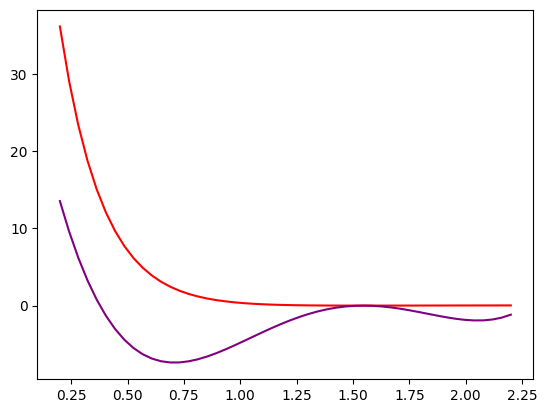

[13.54940691  9.61834731  6.20453064  3.26906425  0.77440618 -1.31563487
 -3.03589951 -4.41987770 -5.49970872 -6.30618116 -6.86873295 -7.21545135
 -7.37307295 -7.36698365 -7.22121869 -6.95846264 -6.60004938 -6.16596213
 -5.67483344 -5.14394517 -4.58922853 -4.02526404 -3.46528155 -2.92116024
 -2.40342861 -1.92126450 -1.48249507 -1.09359680 -0.75969551 -0.48456633
 -0.27063373 -0.11897151 -0.02930279  0.00000000 -0.02808493 -0.10922868
 -0.23775167 -0.40662366 -0.60746374 -0.83054030 -1.06477108 -1.29772315
 -1.51561290 -1.70330604 -1.84431761 -1.92081198 -1.91360285 -1.80215325
 -1.56457551 -1.17763133]


In [46]:
V_r = D_e_Hartree * (1 - np.exp(-alpha_inv_Angs * (r_array - r_eq))) ** 2

V_r_spline = interpolate.UnivariateSpline(r_array, V_r, k=4)

# now define the expansion coefficients to expand the Morse potential as a polynomial
# harmonic
f_spline = V_r_spline.derivative()
k_spline = f_spline.derivative()
g_spline = k_spline.derivative()
h_spline = g_spline.derivative()

k_num = k_spline(r_eq)
g_num = g_spline(r_eq)
h_num = h_spline(r_eq)



V_H = 1/2 * k_num * (r_array - r_eq) ** 2

# cubic
#g = -6 * D_e * alpha ** 3

V_C = V_H + 1/6 * g_num * (r_array - r_eq) ** 3

# quartic 
#h = 14 * D_e * alpha ** 4

V_Q = V_H + V_C + 1/24 * h_num * (r_array - r_eq) ** 4


plt.plot(r_array, V_r, 'red')
#plt.plot(r_array, V_r_spline(r), 'blue')
#plt.plot(r, V_C, 'green')
plt.plot(r_array, V_Q, 'purple')
#plt.xlim(0.75 * r_eq, 1.5 * r_eq)
#plt.ylim(0, 2e-18)
plt.show()
print(V_Q)

In [47]:
def quartic_morse(r, De, k, re, g, h):
    return (1 / 2) * k * (r - re) ** 2 + (1 / 6) * g * (r - re) ** 3 + (1 / 24) * h * (r - re) ** 4
    #return De * (1 - np.exp(-k * (r - re))) ** 2 + g * (r - re) ** 3 + h * (r - re) ** 4

# Initial parameter guesses
initial_guess = [D_e, kappa, r_eq, g, h]

# Perform the curve fit
fit_params, covariance = curve_fit(quartic_morse, r_array, cavity_free_E_array_LiH[:,0], p0=initial_guess, maxfev=10000)

# Extract the optimized parameters
De_fit, k_fit, re_fit, g_fit, h_fit = fit_params

V_fit = quartic_morse(r_array, De_fit, k_fit, re_fit, g_fit, h_fit)

print(V_fit)

[ -1.38688457  -3.74407781  -5.60501731  -7.02005801  -8.03740083
  -8.70309261  -9.06102617  -9.15294025  -9.01841959  -8.69489484
  -8.21764262  -7.61978551  -6.93229203  -6.18397666  -5.40149983
  -4.60936794  -3.82993331  -3.08339425  -2.38779498  -1.75902572
  -1.21082261  -0.75476776  -0.40028922  -0.15466101  -0.02300308
  -0.00828135  -0.11130770  -0.33073995  -0.66308186  -1.10268318
  -1.64173958  -2.27029269  -2.97623011  -3.74528538  -4.56103799
  -5.40491338  -6.25618297  -7.09196409  -7.88722007  -8.61476015
  -9.24523955  -9.74715945 -10.08686694 -10.22855512 -10.13426300
  -9.76387557  -9.07512374  -8.02358442  -6.56268043  -4.64368057]


/Users/ptolley1/miniforge3/envs/work/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

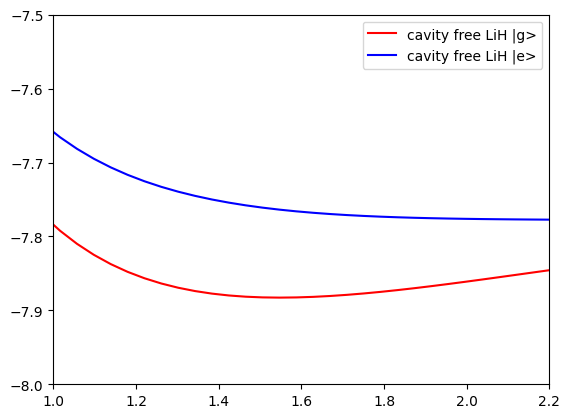

In [56]:
plt.plot(r_array, cavity_free_E_array_LiH[:,0], 'r-', label='cavity free LiH |g>')
plt.plot(r_array, cavity_free_E_array_LiH[:,1], 'b-', label='cavity free LiH |e>')
#plt.plot(r_array, V_fit, label='fit')
plt.xlim(1.0, 2.2)
plt.ylim(-8.0, -7.5)
plt.legend()
plt.show()


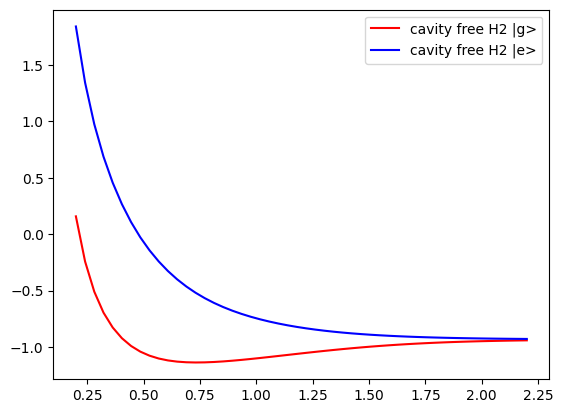

In [57]:
plt.plot(r_array, cavity_free_E_array_H2[:,0], 'r-', label='cavity free H2 |g>')
plt.plot(r_array, cavity_free_E_array_H2[:,1], 'b-', label='cavity free H2 |e>')
plt.legend()
plt.show()

Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

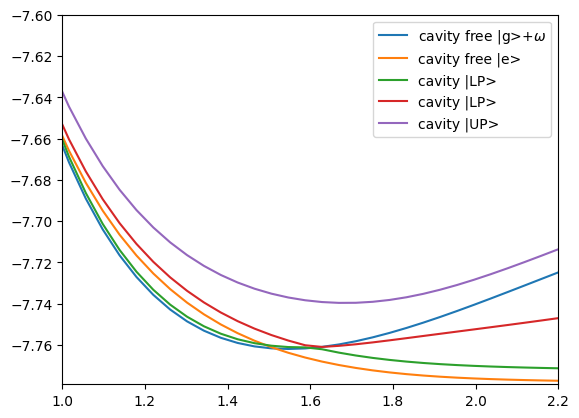

In [64]:
plt.plot(r_array, cavity_free_E_array_LiH[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array_LiH[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array_LiH[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_LiH[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_LiH[:,3], label='cavity |UP>')
plt.xlim(1.0, 2.2)
plt.ylim(-7., -7.6)
plt.legend()
plt.show()